In [1]:
import numpy as np

import torch
import torch.utils.data as data
from torch.autograd.variable import Variable

from imageio import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
import os

from pycocotools.coco import COCO

# Data location

In [2]:
MAIN_FOLDER = "/media/ubuntu/0832e13b-3a8e-4ba1-9bd4-8e0b767de9e7/home/robin/Téléchargements"
IMAGES_FOLDER = os.path.join(MAIN_FOLDER, "train2017")
ANNOTATION_FILE = os.path.join(MAIN_FOLDER, "annotations_trainval2017/annotations/person_keypoints_train2017.json")
CHECKPOINTS_FOLDER = "./cktp/"

# 1. Dataset exploration

## Images

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


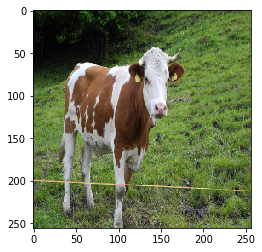

In [3]:
# Homemade image loader
def load_image(image_path):
    image = imread(image_path)
    image = resize(image, (256, 256))
    return image

img = load_image(os.path.join(IMAGES_FOLDER, "000000208459.jpg"))
plt.imshow(img)

## Annotations and COCO api

### COCO api

In [4]:
# Load COCO api instance
coco = COCO(ANNOTATION_FILE)
# Get the image ids
imgIds = coco.getImgIds();

loading annotations into memory...
Done (t=6.61s)
creating index...
index created!


### Keypoints annotations example

#### Example image

In [5]:
# Get an example image
img_id = imgIds[800]
img = coco.loadImgs(img_id)[0]
print('Image id :{}\n'.format(img_id))
print('Image information from the API:\n{}\n'.format(img))

# Local path to avoid downloading data
img_path = os.path.join(IMAGES_FOLDER, img['file_name'])
print('Local image path :\n{}\n'.format(img_path))

Image id :284220

Image information from the API:
{'license': 3, 'file_name': '000000284220.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000284220.jpg', 'height': 512, 'width': 640, 'date_captured': '2013-11-23 04:30:15', 'flickr_url': 'http://farm3.staticflickr.com/2312/2330494156_51691c6eb7_z.jpg', 'id': 284220}

Local image path :
/media/ubuntu/0832e13b-3a8e-4ba1-9bd4-8e0b767de9e7/home/robin/Téléchargements/train2017/000000284220.jpg



#### Annotations for this image

In [6]:
# Get the annotation ids
ann_ids = coco.getAnnIds(imgIds=img['id'])

# Load the corresponding annotation
anns = coco.loadAnns(ann_ids)
anno = anns[0]
print('Annotations:\n{}\n'.format(anno))

# Get the keypoints
keypoints = anno['keypoints']
print('Keypoints:\n{}\n'.format(keypoints))

Annotations:
{'segmentation': [[369.84, 490.33, 373.31, 488.02, 375.62, 466.06, 375.62, 449.88, 375.62, 440.63, 373.31, 419.83, 373.31, 402.49, 373.31, 396.71, 373.31, 382.84, 373.31, 366.66, 373.31, 351.64, 373.31, 341.24, 373.31, 328.52, 375.62, 318.12, 377.93, 312.34, 375.62, 318.12, 362.91, 320.43, 359.44, 320.43, 340.95, 318.12, 336.33, 314.65, 328.23, 312.34, 324.77, 312.34, 314.37, 308.88, 306.28, 308.88, 301.65, 306.56, 305.12, 305.41, 301.65, 305.41, 294.72, 298.47, 291.25, 295.01, 290.09, 295.01, 287.78, 291.54, 286.63, 286.92, 283.16, 278.83, 283.16, 271.89, 283.16, 264.96, 283.16, 255.71, 283.16, 255.71, 283.16, 248.78, 283.16, 245.31, 283.16, 241.84, 283.16, 236.06, 282, 232.6, 279.69, 232.6, 279.69, 230.28, 279.69, 227.97, 279.69, 217.57, 290.09, 214.1, 293.56, 210.64, 293.56, 209.48, 301.65, 209.48, 305.12, 209.48, 312.05, 209.48, 312.05, 229.13, 312.05, 233.75, 308.59, 248.78, 308.59, 248.78, 308.59, 262.65, 309.74, 262.65, 317.83, 270.74, 321.3, 277.67, 325.92, 279.98,

#### Display the example

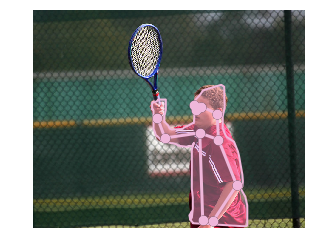

In [7]:
# Read the image from the path
I = imread(img_path)
# Plot the image
plt.imshow(I); plt.axis('off')

# Display the annotation
coco.showAnns(anns)

# 2. Data loaders for Pytorch

## 2.1 Transform keypoints into heatmaps

### 2.1.1 Gaussian heatmap generation

#### Function

In [8]:
def gaussian_heatmap(shape, keypoint_coordinates, std = 1.5):
    """
        Computes a square gaussian kernel

        :param shape: Shape of the output heatmap
        :param keypoint_coordinates: Location of the keypoint
        :param std: Standard deviation

        :return: Heatmap of shape (1,shape,shape)
    """
    
    # Get the coordinates
    x = keypoint_coordinates[0]
    y = keypoint_coordinates[1]
    
    a = np.arange(0, shape, 1, float)
    b = a[:,np.newaxis]

    # Generate the heatmap
    heatmap_raw = np.exp(-(((a-x)**2)/(2*std**2) + ((b-y)**2)/(2*std**2)))
    
    # Normalize
    heatmap_max = np.amax(heatmap_raw)
    heatmap_normalized = heatmap_raw/heatmap_max
    
    # Get it in the accurate format
    heatmap = np.expand_dims(heatmap_raw, axis=0)
    return heatmap

#### Example

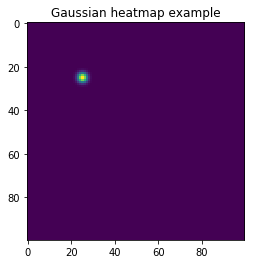

In [9]:
heatmap = gaussian_heatmap(100, (25, 25))
plt.figure()
plt.title('Gaussian heatmap example')
# Here we use heatmap[0] instead of heatmap because of matplotlib format conventions
plt.imshow(heatmap[0])
plt.show()

#### Generate several heatmaps

In [10]:
def gaussian_heatmaps(xs, ys, vs, shape=32, image_height=512, image_width=640, std=1.):
    """
        Computes heatmaps from the keypoints
        :param xs: Array of x coordinates for the keypoints
        :param ys: Array of y coordinates for the keypoints
        :param shape: shape of the heatmaps
        :param image_height: Height of the images the keypoints are for
        :param image_width: Width of the images the keypoints are for
        :param std: Standard deviation of the gaussion function used
        
        :return: Heatmaps as numpy arrays of shape (shape, shape, n_keypoints)
    """
    
    # Rescale keypoints coordinates to the heatmaps scale
    # ys
    height_scale = shape/image_height
    ys = ys*height_scale
    # xs
    width_scale = shape/image_width
    xs = xs*width_scale
    
    
    # Render a heatmap for each joint
    heatmaps = gaussian_heatmap(shape, (xs[0],ys[0]))
    for i, v in enumerate(vs):
        if i!=0:
            # If the joint is visible, generate a heatmaps
            if v!=0:
                new_heatmap = gaussian_heatmap(shape, (xs[i],ys[i]))
            # Otherwise the heatmaps is composed of zeros
            else:
                new_heatmap = np.zeros((1, shape, shape))
            heatmaps = np.append(heatmaps, new_heatmap, axis=0)

    return heatmaps

#### Example

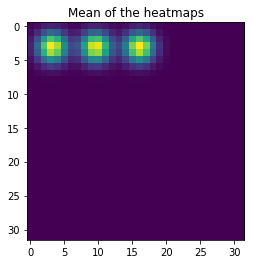

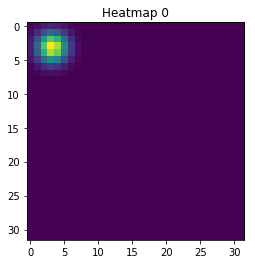

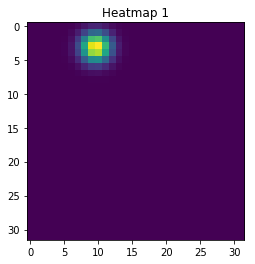

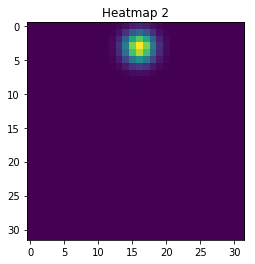

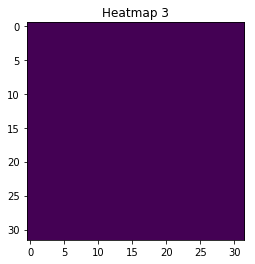

In [11]:
# Example keypoints
x = np.asarray([0.1, 0.3, 0.5, 0.8]) * 640
y = np.asarray([0.1, 0.1, 0.1, 0.1]) * 512
v = np.asarray([1, 1, 1, 0])

# Generate the corresponding heatmaps
heatmaps = gaussian_heatmaps(x, y, v)

# Display heatmaps mean
mean = heatmaps.mean(axis=0)
plt.figure()
plt.title('Mean of the heatmaps')
plt.imshow(mean)

# Display single heatmaps
for i, heatmap in enumerate(heatmaps):
    plt.figure()
    plt.title('Heatmap {}'.format(i))
    plt.imshow(heatmap)

### 2.1.2 Generate heatmaps from MSCOCO keypoints format

#### Transform MSCOCO keypoints format to heatmap generators input format

In [12]:
def get_xs_ys_vs(keypoints):
    """ Splits MSCOCO keypoints notations from [x0, y0, v0, ...] to [x0, ...], [y0, ...] and [v0, ...] """
    keypoints_array = np.asarray(keypoints)
    xs = np.take(keypoints_array, [3*i for i in range(17)])
    ys = np.take(keypoints_array, [3*i+1 for i in range(17)])
    vs = np.take(keypoints_array, [3*i+2 for i in range(17)])
    return xs, ys, vs

#### MSCOCO heatmaps generator

In [13]:
def heatmaps_from_keypoints(keypoints):
    xs, ys, vs = get_xs_ys_vs(keypoints)
    heatmaps = gaussian_heatmaps(xs, ys, vs)
    return heatmaps

#### Example

In [14]:
# Get the keypoints' coordinates
xs, ys, vs = get_xs_ys_vs(keypoints)

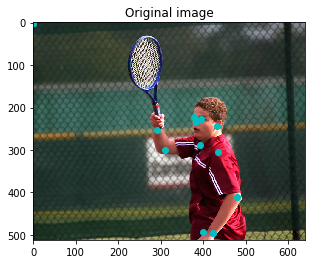

In [15]:
# Original annotated image
plt.figure()
plt.title('Original image')
plt.imshow(I)
plt.plot(xs, ys, 'ro', color='c')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


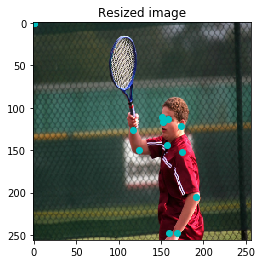

In [16]:
# Resized and annotated image
I_resized = resize(I, (256, 256))
xs_resized = xs * 256/640
ys_resized = ys * 256/512
plt.figure()
plt.title('Resized image')
plt.imshow(I_resized)
plt.plot(xs_resized, ys_resized, 'ro', color='c')

In [17]:
# Generate the heatmaps
heatmaps = heatmaps_from_keypoints(keypoints)
sum = np.mean(heatmaps, axis=0)

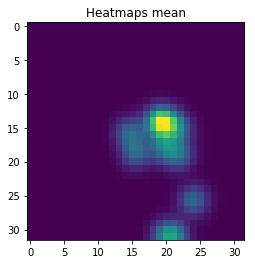

In [18]:
# Heatmaps mean
plt.figure()
plt.title('Heatmaps mean')
plt.imshow(sum)

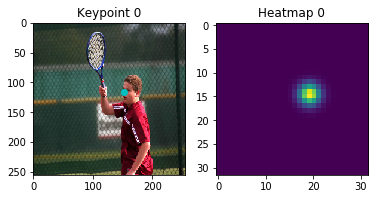

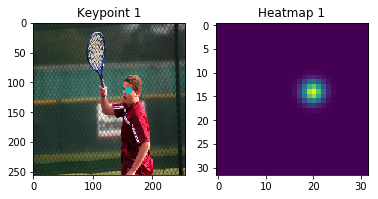

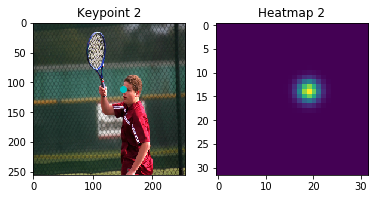

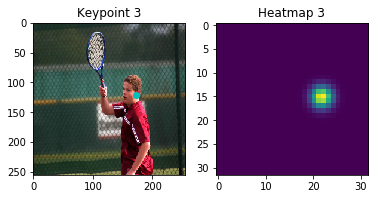

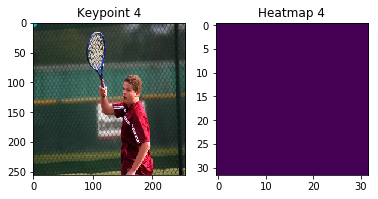

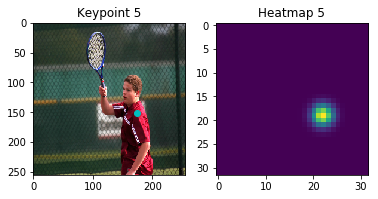

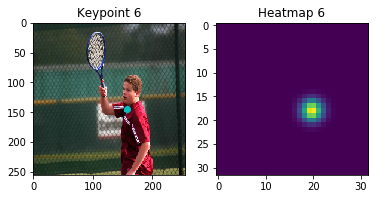

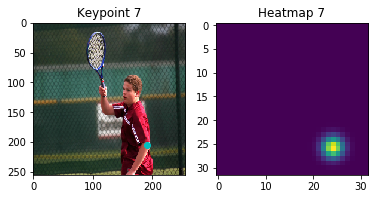

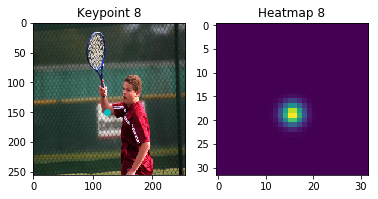

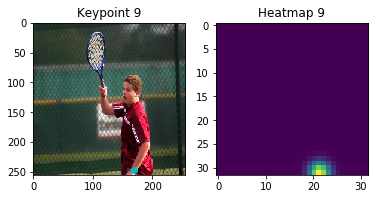

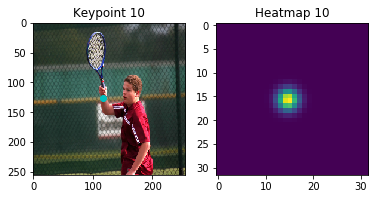

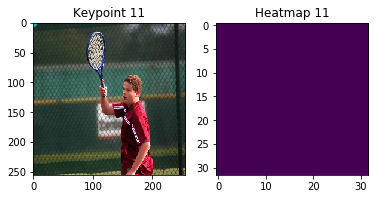

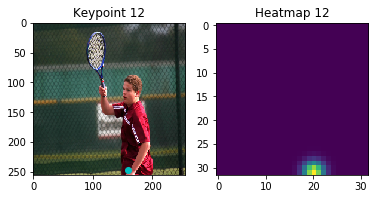

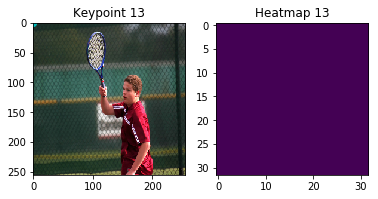

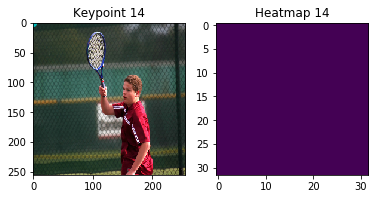

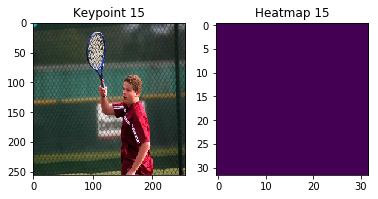

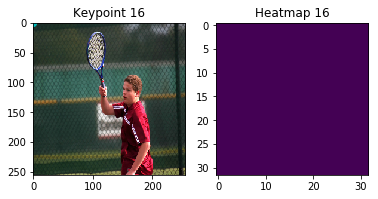

In [19]:
# Display single heatmaps with the corresponding keypoint
for i, heatmap in enumerate(heatmaps):
    
    # Create a figure for the keypoint
    plt.figure()
    
    # Display a keypoint
    plt.subplot(121)
    plt.title('Keypoint {}'.format(i))
    plt.imshow(I_resized)
    plt.plot(xs_resized[i:i+1], ys_resized[i:i+1], 'ro', color='c')
    
    # Display the corresponding heatmap
    plt.subplot(122)
    plt.title('Heatmap {}'.format(i))
    plt.imshow(I_resized)
    plt.imshow(heatmap)

## 2.2 Dataset class

### Class implementation

In [20]:
class MSCOCO(data.Dataset):
    """ Represents a MSCOCO Keypoints dataset """
    
    def __init__(self, images_folder, annotations_json):
        """ Instantiate a MSCOCO dataset """
        super().__init__()
        
        self.images_folder = images_folder
        
        # Load the annotations
        self.annotations = COCO(annotations_json)
        self.img_ids = self.annotations.getImgIds()
    
    def __len__(self):
        return len(self.img_ids)
            
    def __getitem__(self, index):
        """ Returns the index-th image with keypoints annotations, both as tensors """
        
        # Get the image informations
        img_id = self.img_ids[index]
        img = self.annotations.loadImgs(img_id)[0]
        
        # Load the image from the file
        img_path = os.path.join(IMAGES_FOLDER, img['file_name'])
        img_array = load_image(img_path)
        # Black and white images
        if len(img_array.shape)==2:
            # Add a channel axis
            img_array = np.expand_dims(img_array, axis=2)
            # Fill all the axes with the black&white image
            img_array = np.concatenate((img_array, img_array, img_array), axis=2)
        img_array = np.transpose(img_array, (2,1,0))
        
        # Get the keypoints
        annIds = self.annotations.getAnnIds(imgIds=img['id'])
        anns = self.annotations.loadAnns(annIds)
        # Some images do not contain any coco object, so anns = []
        if len(anns)>0:
            keypoints = anns[0]['keypoints'] # anns is a list with only one element
        else:
            # keypoints are not visible so 
            keypoints = [0 for i in range(3*17)]
            
        # Check to avoid errors
        if len(keypoints)!=3*17:
            print('Warning: Keypoints list for image {} has length {} instead of 17'.format(img_id, len(keypoints)))
    
        # Generate the heatmaps
        heatmaps_array = heatmaps_from_keypoints(keypoints)
        
        # Transform arrays into tensors
        img_tensor = torch.from_numpy(img_array)
        img_tensor = img_tensor.float() # Pytorch needs a float tensor
        keypoints_tensor = torch.from_numpy(heatmaps_array).float() # Pytorch needs a float tensor
        
        return img_tensor, keypoints_tensor

### Example

In [21]:
trainset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE)
print('Dataset length: {}'.format(len(trainset)))
img_tensor, keypoints_tensor = trainset[0]
print('Image tensor:{}\n'.format(img_tensor))
print('Keypoints tensor:{}\n'.format(keypoints_tensor))

loading annotations into memory...
Done (t=6.86s)
creating index...
index created!
Dataset length: 118287
Image tensor:
( 0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.5496  0.5729  0.7335
  1.0000  1.0000  1.0000  ...   0.7590  0.7356  0.7972
  1.0000  1.0000  1.0000  ...   0.6945  0.7927  0.7960
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.2806  0.2620  0.2058
  1.0000  1.0000  1.0000  ...   0.2877  0.3359  0.2568
  1.0000  1.0000  1.0000  ...   0.2260  0.2316  0.2325

( 1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.4022  0.4181  0.6435
  1.0000  1.0000  1.0000  ...   0.6575  0.6185  0.6915
  1.0000  1.0000  1.0000  ...   0.6132  0.6950  0.6843
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.3026  0.3238  0.2653
  1.0000  1.0000  1.0000  ...   0.2957  0.3554  0.3379
  1.0000  1.0000  1.0000  ...   0.2520  0.2661  0.3018

( 2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.3051  0.3402  0.4723
  1.0000  1.00

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# 3. Model

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.model_zoo as model_zoo
from torch.nn import init

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, training=True, padding=1, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,
                            out_channels,
                            kernel_size,
                            padding=padding,
                            stride=stride)

        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.training = training

    def forward(self, x):
        x = self.relu(self.conv(x))
        if self.training:
            x = self.batch_norm(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

        self.feature_extraction = nn.Sequential(
                ConvRelu(3, 64, 3),
                ConvRelu(64, 64, 3),
                self.pool,
                ConvRelu(64, 128, 3),
                ConvRelu(128, 128, 3),
                self.pool,
                ConvRelu(128, 128, 3),
                ConvRelu(128, 128, 3),
                self.pool,
                ConvRelu(128, 512, 3),
                ConvRelu(512, 512, 3),
                )
        
        self.features_to_heatmaps = nn.Conv2d(512, 17, 1) # 17 kind of joints, 17 heatmaps

    def forward(self, x):
        x = self.feature_extraction(x)
        heatmaps = self.features_to_heatmaps(x)
        return heatmaps

#### Forward pass example on the dataset

In [23]:
# Instantiate the model
net = Model()

# Get an image
img, keypoints = trainset[0]

# Transform into a pytorch model input
img = Variable(img.unsqueeze(0))
print(img)

# Forward pass
y = net(img)
print(y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Variable containing:
( 0 , 0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.5496  0.5729  0.7335
  1.0000  1.0000  1.0000  ...   0.7590  0.7356  0.7972
  1.0000  1.0000  1.0000  ...   0.6945  0.7927  0.7960
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.2806  0.2620  0.2058
  1.0000  1.0000  1.0000  ...   0.2877  0.3359  0.2568
  1.0000  1.0000  1.0000  ...   0.2260  0.2316  0.2325

( 0 , 1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.4022  0.4181  0.6435
  1.0000  1.0000  1.0000  ...   0.6575  0.6185  0.6915
  1.0000  1.0000  1.0000  ...   0.6132  0.6950  0.6843
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   0.3026  0.3238  0.2653
  1.0000  1.0000  1.0000  ...   0.2957  0.3554  0.3379
  1.0000  1.0000  1.0000  ...   0.2520  0.2661  0.3018

( 0 , 2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   0.3051  0.3402  0.4723
  1.0000  1.0000  1.0000  ...   0.4839  0.4450  0.4812
  1.0000  1.0000  1.0000  ...   0.4554  0.4924

# Training

In [24]:
# Clean the memory
del(net)
del(trainset)
del(imgIds)
del(coco)

#### Configuration

In [25]:
# Model
net = Model()

# Data
trainset = MSCOCO(IMAGES_FOLDER, ANNOTATION_FILE)

# Loss
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters())

# Number of epochs
epochs = 10

# Batch sizes
batch_size_train = 1
batch_size_val = 1

loading annotations into memory...
Done (t=6.48s)
creating index...
index created!


#### Data loaders

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=batch_size_train,
                                         shuffle=True,
                                         num_workers=4
                                        )

#### Training procedure

In [ ]:
# TODO :
#  - logs
#  - save epochs
#  - loading bar
#  - test set (cross testing or just test set)

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Evaluation

In [ ]:
# TODO